In [57]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
from scipy.stats import sem
from matplotlib import cm

from pathlib import Path
from utide import solve, reconstruct

# latitude of tide gauge (needed for tidal analysis)
lat = 56.550

## 1. Load Data

1) Hourly sea level data for Nain (UH#833) downloaded from [UHSLC](http://uhslc.soest.hawaii.edu/data/csv/rqds/atlantic/hourly/h833a.csv). 1963-2018

2) Hourly sea level data for Nain (Station 1430) downloaded from [DFO](https://www.isdm-gdsi.gc.ca/isdm-gdsi/twl-mne/inventory-inventaire/sd-ds-eng.asp?no=1430&user=isdm-gdsi&region=ATL) 2018-2022         

In [2]:
# URL to dataset on UHSLC website
url = "http://uhslc.soest.hawaii.edu/data/csv/rqds/atlantic/hourly/h833a.csv"

# read data into `pandas.DataFrame`
df1 = pd.read_csv(
    url,                                              # URL to dataset on UHSLC website
    header=None,                                      # the dataset doesn't have a header
    names=["year", "month", "day", "hour", "height"], # name columns
    na_values=-32767                                  # set invalid values to NaN
)

# convert columns with date/time information to datetime object
# https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
df1["time"] = pd.to_datetime(df1[["year", "month", "day", "hour"]])

# use the datetime object as index (this will make things much easier)
df1 = df1.set_index("time")

# remove the columns with date/time information
# (all the information is now contained in the index)
df1 = df1.drop(["year", "month", "day", "hour"], axis=1)

# remove all NaN values - UTide auto detects irregularly spaced times
df1 = df1.dropna() 

# add a column to identify the data source
df1["source"] = 'UHSLC'

# convert "height" from [mm] to [m]
df1["height"] = df1["height"]/1000

In [3]:
# display the end of the data
df1.tail()

,height,source
time,,
2018-12-31 19:00:00,1.889,UHSLC
2018-12-31 20:00:00,1.821,UHSLC
2018-12-31 21:00:00,1.633,UHSLC
2018-12-31 22:00:00,1.339,UHSLC
2018-12-31 23:00:00,1.023,UHSLC


In [4]:
# DFO data is in a .csv file on local machine
# read data into `pandas.DataFrame`
df2 = pd.read_csv(
    'DFO1430_2019to2022.csv',                   # Data downloaded from DFO 1430
    header=7,                                   # Seven line header
    parse_dates=[['Obs_date', 'Obs_time']],     # Identify date & time columns
)

# convert columns with date/time information to datetime object
df2["time"] = pd.to_datetime(df2["Obs_date_Obs_time"])

# remove the columns with date/time information
df2 = df2.drop(["Obs_date_Obs_time"], axis=1)

# use the datetime object as index
df2 = df2.set_index("time")

# rename sea level column to match df1
df2.rename(columns={'SLEV(metres)':'height'}, inplace=True)

# add a column to identify the data source
df2["source"] = 'DFO'

# display the start of the data
df2.head()

,height,source
time,,
2019-01-01 00:00:00,0.77,DFO
2019-01-01 01:00:00,0.67,DFO
2019-01-01 02:00:00,0.73,DFO
2019-01-01 03:00:00,0.94,DFO
2019-01-01 04:00:00,1.24,DFO


In [5]:
frames = ([df1, df2])
df = pd.concat(frames)
df

,height,source
time,,
1963-10-17 05:00:00,0.53,UHSLC
1963-10-17 06:00:00,0.65,UHSLC
1963-10-17 07:00:00,0.97,UHSLC
1963-10-17 08:00:00,1.38,UHSLC
1963-10-17 09:00:00,1.87,UHSLC
...,...,...
2021-12-31 00:00:00,0.99,DFO
2021-12-31 01:00:00,0.71,DFO
2021-12-31 02:00:00,0.59,DFO


In [6]:
df["anomaly"] = df["height"]/df["height"].mean()
df

,height,source,anomaly
time,,,
1963-10-17 05:00:00,0.53,UHSLC,0.370791
1963-10-17 06:00:00,0.65,UHSLC,0.454743
1963-10-17 07:00:00,0.97,UHSLC,0.678617
1963-10-17 08:00:00,1.38,UHSLC,0.965455
1963-10-17 09:00:00,1.87,UHSLC,1.308261
...,...,...,...
2021-12-31 00:00:00,0.99,DFO,0.692609
2021-12-31 01:00:00,0.71,DFO,0.496720
2021-12-31 02:00:00,0.59,DFO,0.412767


### Figure: Raw Time Series

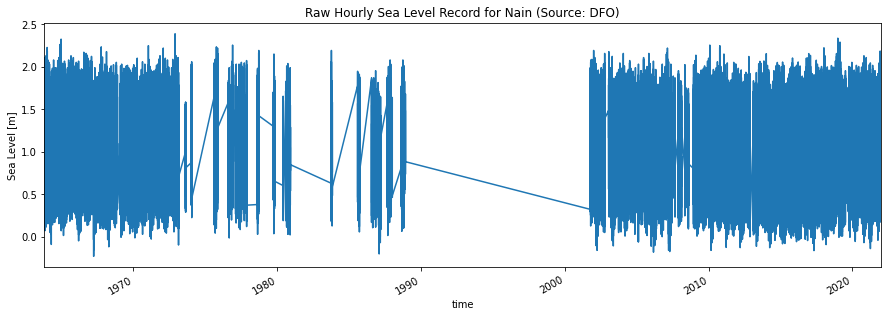

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot "height" column against index (which is the a datetime object)
df["anomaly"].plot(
    ax=ax,
)

# title and axis label
ax.set(
    title="Raw Hourly Sea Level Record for Nain (Source: DFO)",
    ylabel="Sea Level [m]"
)

plt.show()

## 2. Tidal Analysis

From [UTide GitHub page](https://github.com/wesleybowman/UTide):

```
coef = solve(time, time_series_u, time_series_v,
             lat=30,
             nodal=False,
             trend=False,
             method='ols',
             conf_int='linear',
             Rayleigh_min=0.95,) #Based on previous analysis, we are adjusting the Rayleight minimum to 1.2
```

Here, the entire timeseries is run through the UTides 'solve' function. This assumes that the tides have remained constant over time. The function will resolve as many tidal constituents as meet the threshold (based on a signal to noise ratio) and will output the amplitude and frequency for those constituents. 

In [8]:
# make a time variable in floating point days
time = mdates.date2num(df.index.to_pydatetime())

# use UTide to run tidal analysis
coef = solve(
    time, df["anomaly"].values,   # input variables: time and sea level as numpy arrays
    lat=lat,       # latitude of tide gauge
    nodal=False,       
    trend=False,
    method="ols",
    conf_int="linear",
    Rayleigh_min=1.2,
    verbose=False       # no messages
)

#coef

Here, the tides are reconstructed for the period of record:

In [9]:
tide = reconstruct(time, coef)

prep/calcs ... done.


Here, the tides and raw gage data are combined in a new DataFrame. The residuals are calculated and added to the DataFrame. The datetime is assigned to the index, and the index is reset to include timestamps where there is no data (this is done for visualization purposes). Compiling into a new DataFrame structure will allow us to apply the grouper method and visualize seasons, monthly or yearly aggregations of the data.

In [10]:
# create a new DataFrame to store the model outputs
dv = pd.DataFrame(columns=["time","anomaly", "tides", "residual"])

# assign data to each of the columns
dv["time"] = df.index
dv["anomaly"] = df["anomaly"].tolist()
dv["tides"] = tide.h.tolist()

# set datetime index
dv = dv.set_index("time")

dv["residual"] = (df["anomaly"] - tide.h).tolist()

# create a new index from the date range specified
# use hourly frequency to match the hourly gage data
new_index = pd.date_range('1963-10-17 ', '2021-12-31', freq='H')

# reassign new index to df
dv=dv.reindex(index=new_index)
dv.index.name = "time"

dv

,anomaly,tides,residual
time,,,
1963-10-17 00:00:00,NaN,NaN,NaN
1963-10-17 01:00:00,NaN,NaN,NaN
1963-10-17 02:00:00,NaN,NaN,NaN
1963-10-17 03:00:00,NaN,NaN,NaN
1963-10-17 04:00:00,NaN,NaN,NaN
...,...,...,...
2021-12-30 20:00:00,1.462174,1.456035,0.006139
2021-12-30 21:00:00,1.392214,1.422076,-0.029862
2021-12-30 22:00:00,1.203321,1.273492,-0.070172


### Figure: Sea level, tides, and non-tidal components

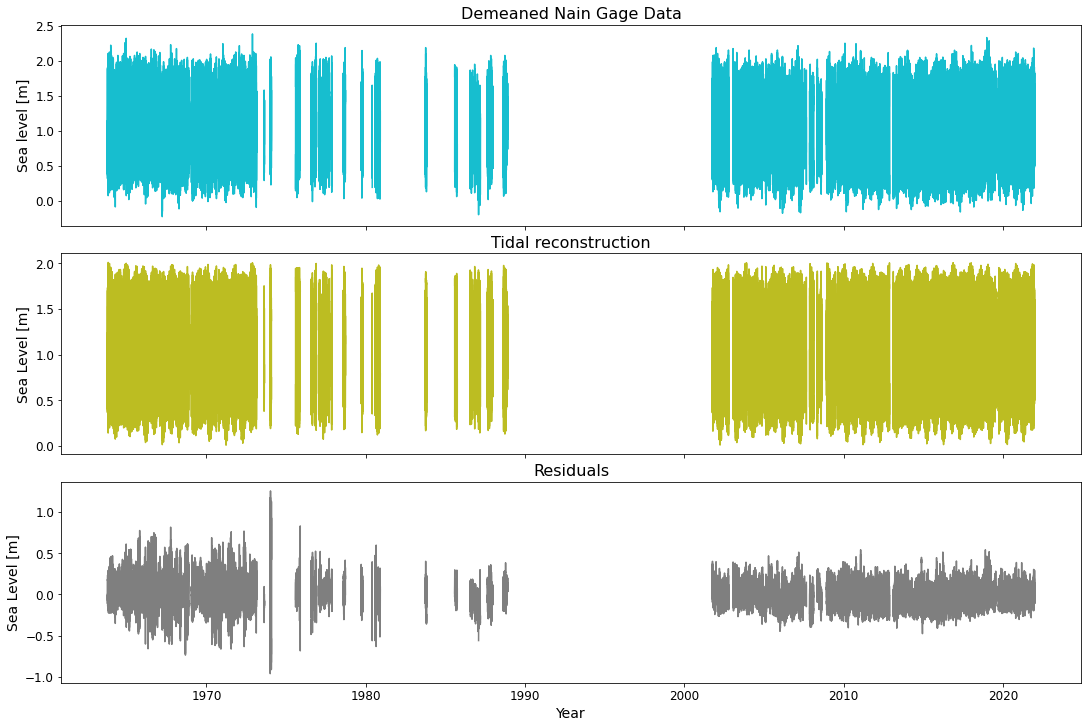

In [11]:
# Set parameters for subplots
rcParams["axes.titlesize"] = 16
rcParams["axes.labelsize"] = 14
rcParams["ytick.labelsize"] = 12
rcParams["xtick.labelsize"] = 12

# Create subplots
fig, ax = plt.subplots(3, 1, figsize=(15, 10), 
                      sharex=True, constrained_layout = True)

# Plot the Demeaned Raw Data

ax[0].plot(dv["anomaly"], color='tab:cyan')

# title and axis label
ax[0].set(
    title=f"Demeaned Nain Gage Data",
    ylabel=f"Sea level [m]"
)

# -------------

# Plot the Tidal Reconstruction

ax[1].plot(dv["tides"], color='tab:olive')

# title and axis label
ax[1].set(
    title=f"Tidal reconstruction",
    ylabel=f"Sea Level [m]",
)

# -------------

# Plot the Residuals

ax[2].plot(dv["residual"], color='tab:grey')

# title and axis label
ax[2].set(
    title=f"Residuals",
    ylabel=f"Sea Level [m]",
    xlabel=f"Year"
)

#plt.savefig('nain_sea_level.png', facecolor='w')
plt.show()

### Figure: zoomed in on 2021

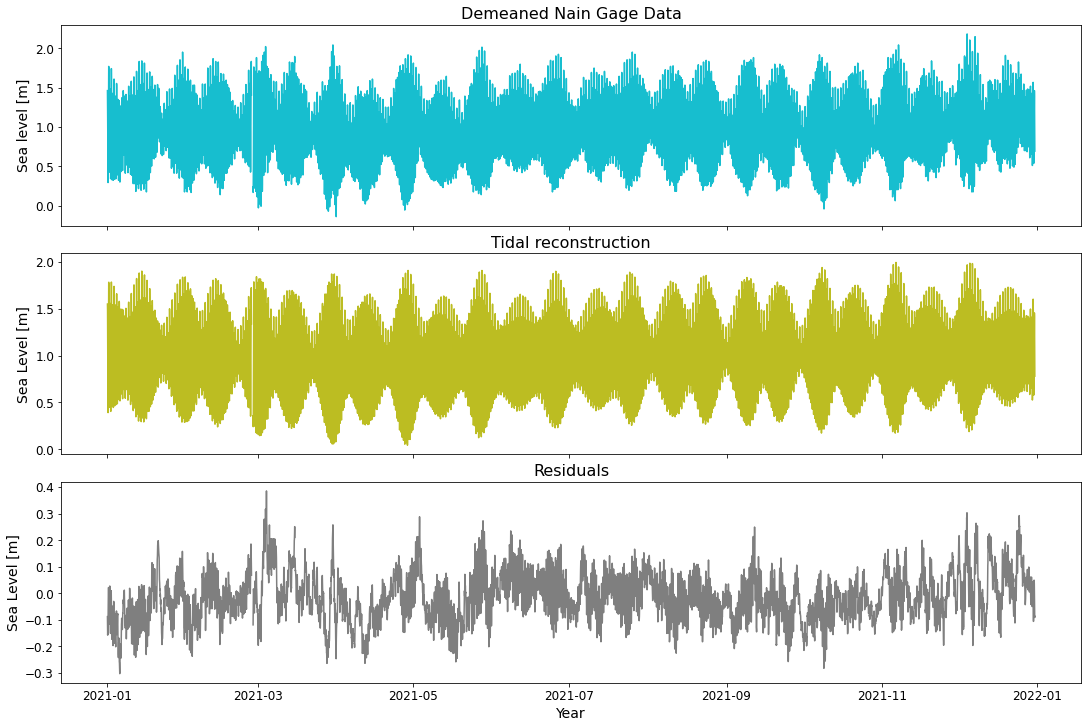

In [12]:
# Create subplots
fig, ax = plt.subplots(3, 1, figsize=(15, 10), 
                      sharex=True, constrained_layout = True)

# Plot the Demeaned Raw Data

ax[0].plot(dv["anomaly"].loc['2021':'2022'], color='tab:cyan')

# title and axis label
ax[0].set(
    title=f"Demeaned Nain Gage Data",
    ylabel=f"Sea level [m]"
)

# -------------

# Plot the Tidal Reconstruction

ax[1].plot(dv["tides"].loc['2021':'2022'], color='tab:olive')

# title and axis label
ax[1].set(
    title=f"Tidal reconstruction",
    ylabel=f"Sea Level [m]",
)

# -------------

# Plot the Residuals

ax[2].plot(dv["residual"].loc['2021':'2022'], color='tab:grey')

# title and axis label
ax[2].set(
    title=f"Residuals",
    ylabel=f"Sea Level [m]",
    xlabel=f"Year"
)

#plt.savefig('nain_sea_level.png', facecolor='w')
plt.show()

## 3. Residuals over time

In [93]:
# get the mean of the residuals for each month
mr = dv["residual"].groupby(pd.Grouper(freq="M")).mean()

# calculate the mean error for the binned-monthly residuals
mr_err = dv["residual"].groupby(pd.Grouper(freq="M")).sem()

# time array of months because plotting with the index on a grouped
# dataframe is giving me problems, this is an inelegant hack
t = pd.date_range('1963-10 ', '2022-01', freq='M')

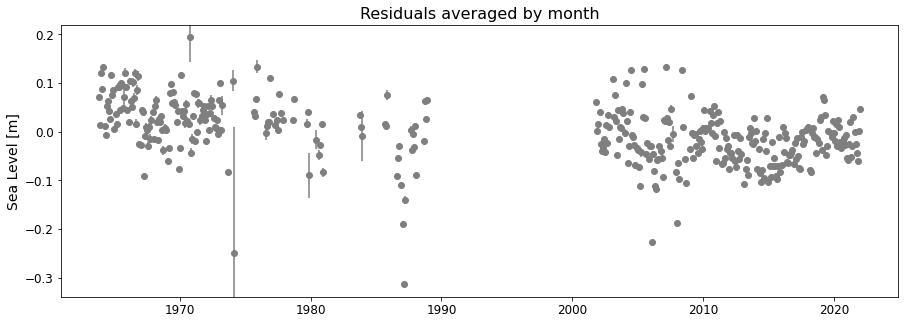

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# plot monthly mean of residuals and mean error
ax.errorbar(
    t, mr,
    yerr=mr_err,
    fmt="o",
    color='tab:grey'
)

# title and axis label
ax.set(
    title=f"Residuals averaged by month",
    ylabel=f"Sea Level [m]",
)
plt.show()

As of now, the only positional data that can be trusted is 2001 - present:

### Figure: vertically-stable residuals by month

In [15]:
# get the mean of the residuals for each month
mr = dv["residual"].loc["2001":].groupby(pd.Grouper(freq="M")).mean()

# calculate the mean error for the binned-monthly residuals
mr_err = dv["residual"].loc["2001":].groupby(pd.Grouper(freq="M")).sem()

# time array of months because plotting with the index on a grouped
# dataframe is giving me problems, this is an inelegant hack
t = pd.date_range('2001-01 ', '2022-01', freq='M')

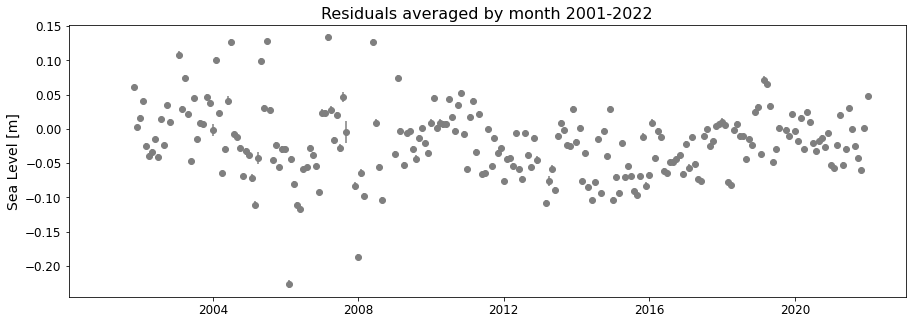

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# plot monthly mean of residuals and mean error
ax.errorbar(
    t, mr,
    yerr=mr_err,
    fmt="o",
    color='tab:grey'
)

# title and axis label
ax.set(
    title=f"Residuals averaged by month 2001-2022",
    ylabel=f"Sea Level [m]",
)
plt.show()

I don't think there's a trend per se, but it looks like there is structure in the data.

Let's look at the percentiles for the residuals:

In [106]:
def p_5(x):
    return x.quantile(0.005) # 5th percentile

def p_10(x):
    return x.quantile(0.01) # 10th percentile

def p_25(x):
    return x.quantile(0.25) # 25th percentile

def p_50(x):
    return x.quantile(0.50) # 50th percentile

def p_75(x):
    return x.quantile(0.75) # 75th percentile

def p_90(x):
    return x.quantile(0.9) # 90th percentile

def p_95(x):
    return x.quantile(0.95) # 95th percentile

In [188]:
vals = [p_5, p_10, p_25, p_50, p_75, p_90, p_95] # list of functions

# group residuals by month
# apply percentile function to monthly aggregate data
percentiles = dv["residual"].groupby(pd.Grouper(freq="M")).agg(vals)

In [189]:
# display the results
percentiles

,p_5,p_10,p_25,p_50,p_75,p_90,p_95
time,,,,,,,
1963-10-31,-0.126696,-0.114808,-0.001231,0.071358,0.137405,0.205964,0.242747
1963-11-30,-0.213637,-0.192681,-0.069427,0.007896,0.087946,0.168843,0.203937
1963-12-31,-0.151894,-0.121518,0.016688,0.108575,0.224331,0.291902,0.338922
1964-01-31,-0.210692,-0.204964,-0.021144,0.081793,0.186082,0.292549,0.353363
1964-02-29,-0.040162,-0.029728,0.059037,0.109782,0.194875,0.288416,0.328705
...,...,...,...,...,...,...,...
2021-08-31,-0.201571,-0.185734,-0.081361,-0.023949,0.029005,0.074068,0.094619
2021-09-30,-0.217747,-0.206124,-0.101584,-0.045605,0.007583,0.062761,0.091092
2021-10-31,-0.251302,-0.221141,-0.101624,-0.058228,-0.014418,0.022573,0.042718


### Figure: Percentiles of residuals

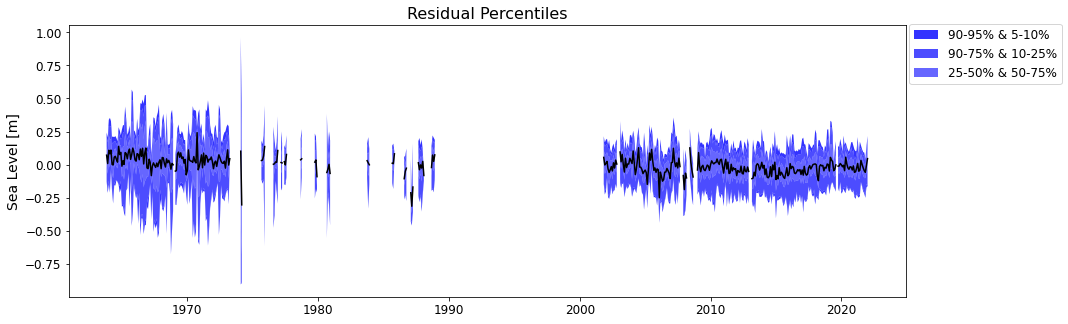

In [196]:
fig, ax = plt.subplots(figsize=(15,5))

# plot the median in black
ax.plot(percentiles.p_50, color='k')

# 5-10 & 90-95 percentiles
ax.fill_between(
    percentiles.index, 
    percentiles.p_5, percentiles.p_10, 
    color='blue', alpha=0.8, edgecolor='none'
)

ax.fill_between(
    percentiles.index, 
    percentiles.p_95, percentiles.p_90, 
    color='blue', alpha=0.8, edgecolor='none',
    label= '90-95% & 5-10%'
)


# 10-25 & 90-75 percentiles
ax.fill_between(
    percentiles.index, 
    percentiles.p_10, percentiles.p_25, 
    color='blue', alpha=0.7, edgecolor='none'
)

ax.fill_between(
    percentiles.index, 
    percentiles.p_90, percentiles.p_75, 
    color='blue', alpha=0.7, edgecolor='none',
    label='90-75% & 10-25%'
)

# 25-50 & 75-50 percentiles
ax.fill_between(
    percentiles.index, 
    percentiles.p_25, percentiles.p_50, 
    color='blue', alpha=0.6, edgecolor='none'
)

ax.fill_between(
    percentiles.index, 
    percentiles.p_75, percentiles.p_50, 
    color='blue', alpha=0.6, edgecolor='none',
    label='25-50% & 50-75%'
)

# title and axis label
ax.set(
    title=f"Residual Percentiles",
    ylabel=f"Sea Level [m]"
)

fig.legend(bbox_to_anchor=[1.05, 0.9], fontsize=12)

plt.show()

Same figure below, but with lines instead of shading:

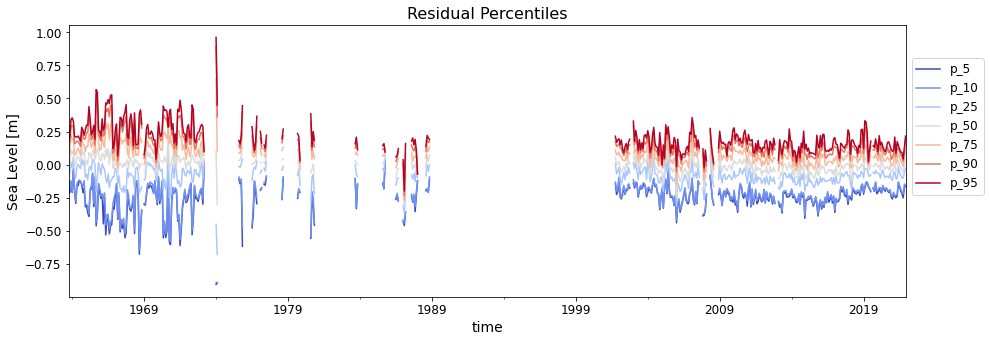

In [195]:
percentiles.plot(
    cmap='coolwarm',
    figsize=(15,5)
)

plt.legend(bbox_to_anchor=[1., 0.9], fontsize=12)
plt.ylabel('Sea Level [m]')
plt.title('Residual Percentiles')

plt.show()

Zooming in to the time frame when we can be sure that the vertical position of the gage is stable:

In [192]:
# group residuals by month
# restrict analysis to the years 2001-2022
# apply percentile function to monthly aggregate data
percentiles_stable = dv["residual"].loc['2001':'2022'].groupby(pd.Grouper(freq="M")).agg(vals)

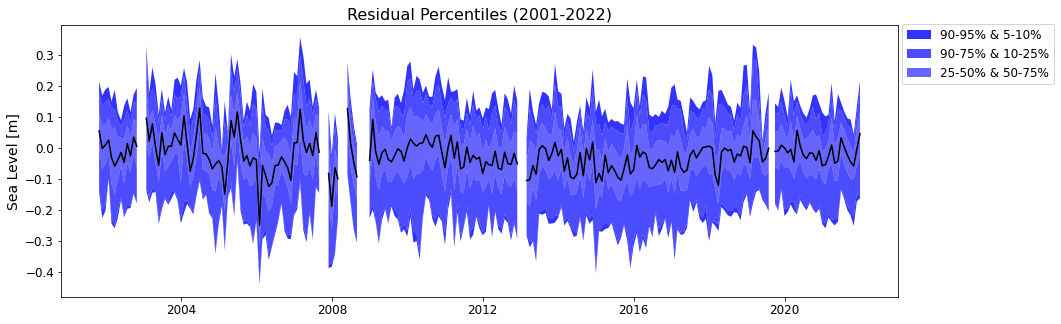

In [193]:
fig, ax = plt.subplots(figsize=(15,5))

# plot the median in black
ax.plot(percentiles_stable.p_50, color='k')

# 5-10 & 90-95 percentiles
ax.fill_between(
    percentiles_stable.index, 
    percentiles_stable.p_5, percentiles_stable.p_10, 
    color='blue', alpha=0.8, edgecolor='none'
)

ax.fill_between(
    percentiles_stable.index, 
    percentiles_stable.p_95, percentiles_stable.p_90, 
    color='blue', alpha=0.8, edgecolor='none',
    label= '90-95% & 5-10%'
)


# 10-25 & 90-75 percentiles
ax.fill_between(
    percentiles_stable.index, 
    percentiles_stable.p_10, percentiles_stable.p_25, 
    color='blue', alpha=0.7, edgecolor='none'
)

ax.fill_between(
    percentiles_stable.index, 
    percentiles_stable.p_90, percentiles_stable.p_75, 
    color='blue', alpha=0.7, edgecolor='none',
    label='90-75% & 10-25%'
)

# 25-50 & 75-50 percentiles
ax.fill_between(
    percentiles_stable.index, 
    percentiles_stable.p_25, percentiles_stable.p_50, 
    color='blue', alpha=0.6, edgecolor='none'
)

ax.fill_between(
    percentiles_stable.index, 
    percentiles_stable.p_75, percentiles_stable.p_50, 
    color='blue', alpha=0.6, edgecolor='none',
    label='25-50% & 50-75%'
)

# title and axis label
ax.set(
    title=f"Residual Percentiles (2001-2022)",
    ylabel=f"Sea Level [m]"
)

fig.legend(bbox_to_anchor=[1.05, 0.9], fontsize=12)

plt.show()

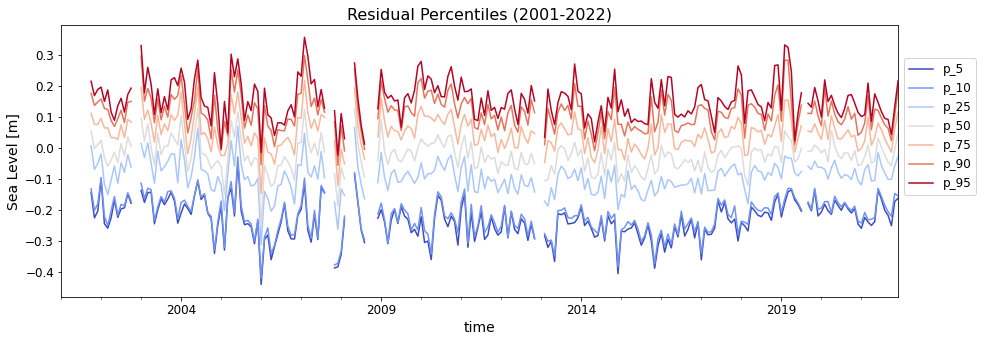

In [198]:
percentiles_stable.plot(
    cmap='coolwarm',
    figsize=(15,5)
)

plt.legend(bbox_to_anchor=[1., 0.9], fontsize=12)
plt.ylabel('Sea Level [m]')
plt.title('Residual Percentiles (2001-2022)')

plt.show()

## 4. Climatology

Here, seasonal averages for the years 2001-2022 (where the vertical position of the gage can be considered stable and reliable) are calculated:

In [20]:
# first, we thransform the dataframe into an xarray format

ds = dv.loc["2001":"2022"].to_xarray()

Here, the monthly means are averaged by month:

In [21]:
clim = ds.groupby("time.month").mean("time")

#### Figure: Seasonal averages

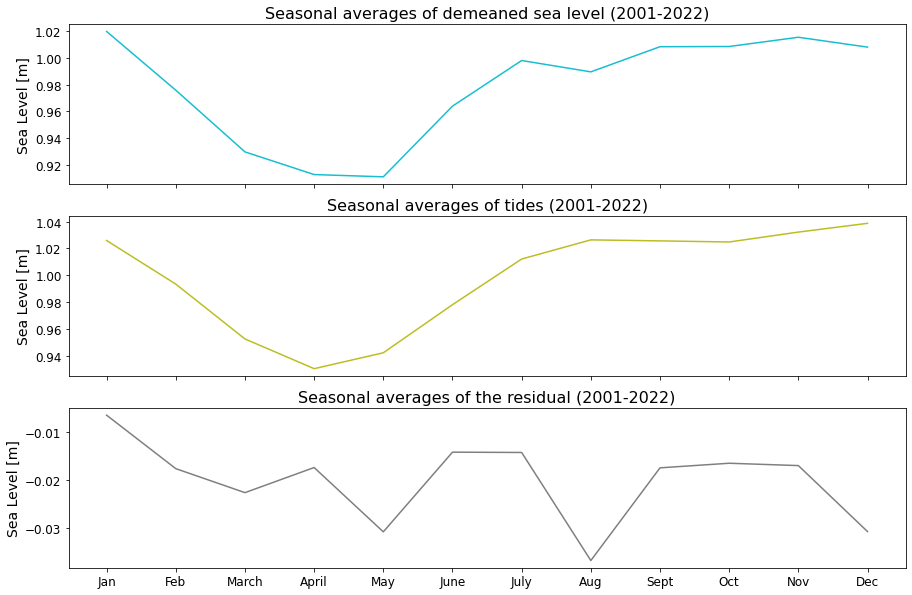

In [53]:
fig, ax = plt.subplots(3,1, figsize=(15,10), 
                       sharex=True)

# Plot Seasonal Demeaned Sea Level

ax[0].plot(clim["anomaly"], color='tab:cyan')

# title and axis label
ax[0].set(
    title=f"Seasonal averages of demeaned sea level (2001-2022)",
    ylabel=f"Sea Level [m]",
)

# Plot Seasonal Tides

ax[1].plot(clim["tides"], color='tab:olive')

# title and axis label
ax[1].set(
    title=f"Seasonal averages of tides (2001-2022)",
    ylabel=f"Sea Level [m]",
)

# Plot Seasonal Residual

ax[2].plot(clim["residual"], color='tab:grey')

# title and axis label
ax[2].set(
    title=f"Seasonal averages of the residual (2001-2022)",
    ylabel=f"Sea Level [m]"
)

# name x-ticks by month
labels = ['Jan', 'Feb', 'March', 'April', 'May', 'June',
         'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
ax[2].set_xticks(
    [0,1,2,3,4,5,6,7,8,9,10,11], 
    labels)

plt.show()

Very similar seasonal patterns in the demeaned sea level data and the tidal reconstruction: dampening during the early winter months to a low in April, followed by a rise into the summer, which plateaus around July and remains constant through the fall. Residuals peak in Jan/Feb and are at their lowest in May and August. Kind of surprising that they are so low in December and so high in January?

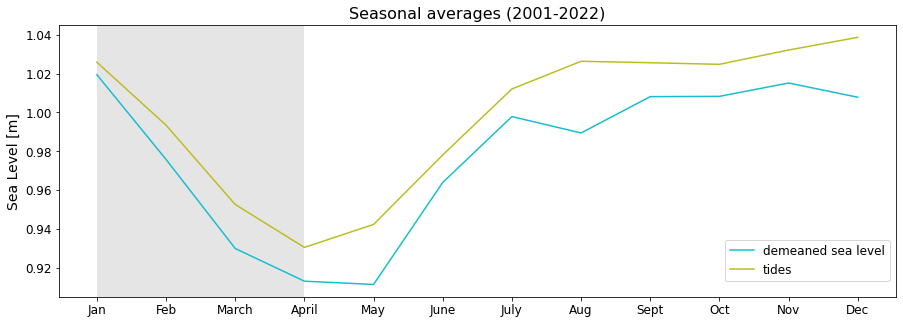

In [55]:
fig, ax = plt.subplots(figsize=(15,5))

# Plot Seasonal Demeaned Sea Level

ax.plot(clim["anomaly"], color='tab:cyan',
       label='demeaned sea level')

# title and axis label
ax.set(
    title=f"Seasonal averages of demeaned sea level (2001-2022)",
    ylabel=f"Sea Level [m]",
)

# Plot Seasonal Tides

ax.plot(clim["tides"], color='tab:olive',
       label='tides')

# title and axis label
ax.set(
    title=f"Seasonal averages (2001-2022)",
    ylabel=f"Sea Level [m]",
)

# add legend to figure
fig.legend(bbox_to_anchor=[0.9, 0.3], fontsize=12)

# add shading to area of interest
plt.axvspan(0, 3, color='grey', alpha=0.2, lw=0)

# name x-ticks by month
labels = ['Jan', 'Feb', 'March', 'April', 'May', 'June',
         'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
ax.set_xticks(
    [0,1,2,3,4,5,6,7,8,9,10,11], 
    labels)

plt.show()

Is this period of significant change in sea level readings & tide strength during the winter months reflective of oceanographic, atmospheric, or cryospheric processes?